In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/', one_hot=True)

In [0]:
#parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 64

#network parameters
image_dim = 784
hidden_dim = 512
latent_dim = 2

In [0]:
# A custom initializetion (see Xavier Glorot init)
def glorot_init(shape):
  return tf.random_normal(shape=shape, stddev=1./tf.sqrt(shape[0]/2.))

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim,  latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}

biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [0]:
# Building the encoder
input_image= tf.placeholder(tf.float32, shape=[None,image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0)
z = z_mean + tf.exp(z_std / 2) * eps

In [0]:
# Building the decoder
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [6]:
# Define VAE loss
def vae_loss(x_reconstructed, x_true):
  # Reconstruction loss
  encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
              + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
  encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
  
  # KL divergence loss
  kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
  kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
  return tf.reduce_sum(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

init = tf.global_variables_initializer()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Step 1, Loss: 40406.820312
Step 1000, Loss: 10706.822266
Step 2000, Loss: 10696.720703
Step 3000, Loss: 10567.726562
Step 4000, Loss: 10138.757812
Step 5000, Loss: 10971.485352
Step 6000, Loss: 9950.511719
Step 7000, Loss: 9277.628906
Step 8000, Loss: 11209.221680
Step 9000, Loss: 10471.687500
Step 10000, Loss: 9841.341797
Step 11000, Loss: 9155.525391
Step 12000, Loss: 9907.515625
Step 13000, Loss: 10021.975586
Step 14000, Loss: 9488.644531
Step 15000, Loss: 9666.201172
Step 16000, Loss: 9615.199219
Step 17000, Loss: 9823.886719
Step 18000, Loss: 9715.958984
Step 19000, Loss: 9337.137695
Step 20000, Loss: 9142.777344
Step 21000, Loss: 9272.330078
Step 22000, Loss: 9745.546875
Step 23000, Loss: 9385.741211
Step 24000, Loss: 8989.960938
Step 25000, Loss: 9614.359375
Step 26000, Loss: 9934.974609
Step 27000, Loss: 9685.973633
Step 28000, Loss: 9959.724609
Step 29000, Loss: 9687.623047
Step 30000, Loss: 10059.042969


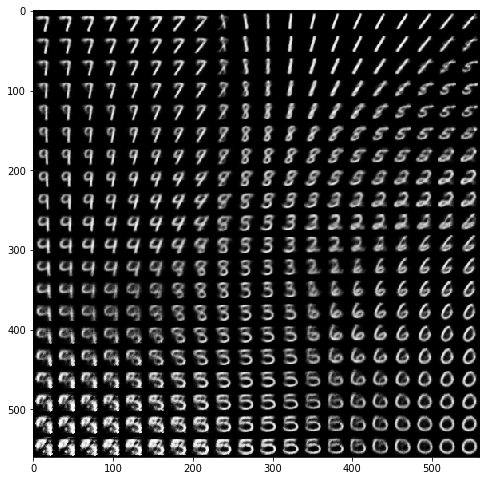

In [7]:
with tf.Session() as sess:
  sess.run(init)

  for i in range(1, num_steps+1):
    batch_x, _ = mnist.train.next_batch(batch_size=batch_size)
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i%1000 == 0  or i==1:
      print('Step %i, Loss: %f' % (i, l))
  noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
  # Rebuild the decode to create image from noise
  decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
  decoder = tf.nn.tanh(decoder)
  decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
  decoder = tf.nn.sigmoid(decoder)

  n = 20
  x_axis = np.linspace(-3, 3, n)
  y_axis = np.linspace(-3, 3, n)

  canvas = np.empty((28*n, 28*n))
  for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
      z_mu = np.array([[xi, yi]] * batch_size)
      x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
      canvas[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = \
      x_mean[0].reshape(28, 28)
  plt.figure(figsize=(8, 10))
  Xi, Yi = np.meshgrid(x_axis, y_axis)
  plt.imshow(canvas, origin='upper', cmap='gray')
  plt.show()